来源：https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98

In [1]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import pymc3 as pm

import theano.tensor as tt

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
d:\python\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 本文的目标

利用logistic function预测时刻t时入睡的概率

## $P(sleep|time)=\frac{1}{1+e^{\beta t+\alpha}}$

并使用MCMC确定参数 $\beta$ 和 $\alpha$

## MCMC

Markov Chain是一种下一时刻状态只依赖当前状态的过程。Monte Carlo是一种通用的技术，通过不断生成随机的样本，最终获得问题的数值解，比如对于一个概率分布而言，可以计算该分布的期望，中位数等等。

所以MCMC就是不断采样以获得问题的解；并且利用Markov Chain技术采样，即下个样本只与当前样本有关。由Markov Chain的性质可知，样本最后会收敛于某个分布（平稳分布，要求样本间的转移满足细致平稳条件）。

MCMC可以看成在样本空间中随机行走，最终样本会收敛于真实分布。

这里采用一种特定的MCMC算法 --- Metropolis Hastings算法。这个算法的细致平稳条件如下：

$p(i)q(i,j)\alpha(i,j)=p(j)q(j,i)\alpha(j,i)$

这里q(i,j)为转移矩阵Q的i行j列，为了简单，设Q为全1矩阵。$\alpha(i,j)$为接受率，假设当前状态为i（本问题中就是要确定的参数），想要转移到j，这里通过检查状态j是否与观测值相符来确定是接受j作为下个状态，还是拒绝j，仍以i为下个状态。

## Python Implementation

In [2]:
sleep_data = pd.read_csv('data/sleep_data.csv')

# labels for plotting
sleep_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']

In [3]:
print('Number of sleep observations %d' % len(sleep_data))

Number of sleep observations 11340


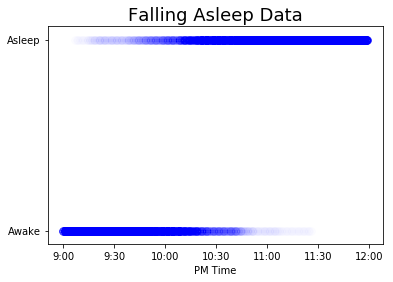

In [4]:
# Sleep data
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('PM Time'); 
plt.title('Falling Asleep Data', size = 18)
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

### 调用PyMC3

In [5]:
# Sort the values by time offset
# time offset 从 60 到 119， 对应的时间是 21:00:00 到 23:59:00
sleep_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(sleep_data.loc[:, 'time_offset'])

# Observations are the indicator
sleep_obs = np.array(sleep_data.loc[:, 'indicator'])

In [6]:
N_SAMPLES = 200

with pm.Model() as sleep_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed data
    observed = pm.Bernoulli('obs', p, observed=sleep_obs)
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    sleep_trace = pm.sample(N_SAMPLES, step=step, njobs=4);

Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 2800/2800 [1:01:49<00:00,  1.06s/draws]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
# Extract the alpha and beta samples
alpha_samples = sleep_trace[:]['alpha']
beta_samples = sleep_trace[:]['beta']

In [16]:
len(sleep_trace)

200

Text(0, 0.5, 'Probability Density')

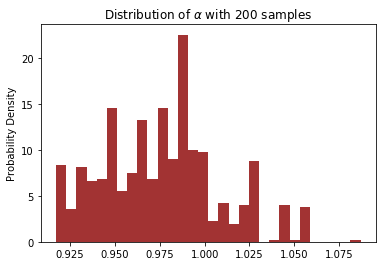

In [20]:
plt.title(r"""Distribution of $\alpha$ with %d samples""" % N_SAMPLES)
plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')

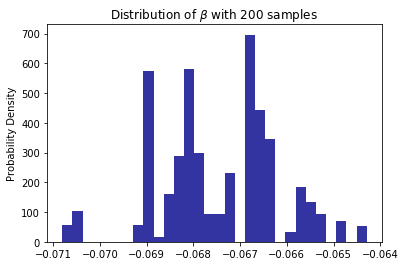

In [21]:
plt.title(r"""Distribution of $\beta$ with %d samples""" % N_SAMPLES)
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');